In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from skopt import BayesSearchCV
from sklearn.metrics import mean_absolute_error, r2_score

# Plot Predictions

In [56]:
# Load data
file_path = "Dataset_Dolar.csv"
df = pd.read_csv(file_path)
df = df[['t', 'ano', 'mes', 'cotacao', 'ipca_acumulado', 'cpi', 'selic',
         'divida_pp', 'fed_rate']]

# Create lag features (6 months shift)
for shift_val in range(1, 7):
    for column in ['cotacao', 'ipca_acumulado', 'cpi', 'selic', 'divida_pp', 'fed_rate']:
        column_name = f'{column}_lag{shift_val}'
        df[column_name] = df[column].shift(shift_val)
df = df.dropna()  # Drop rows with NaN to avoid bias

# Define features and target
X = df.drop(columns=['t', 'ano', 'mes', 'cotacao', 'ipca_acumulado', 'cpi', 'selic',
                     'divida_pp', 'fed_rate'])  # Use only 6-month-shifted features
y = df['cotacao']

Best parameters from training: OrderedDict({'C': 1000.0, 'epsilon': 0.0009323070214764428, 'gamma': 0.0006982871820473105, 'kernel': 'rbf'})
CV score (MAE): 0.1907
Test MAE (next 1 months): 0.2012
Test R² (next 1 months): -42.4535

Outlier Details (Next 1 Months):
       Date  Actual Cotacao  Predicted Cotacao  Lower Bound  Upper Bound  \
269  2022-6          5.2562           4.870624     4.549996     5.191252   

     Is Outlier  
269        True  


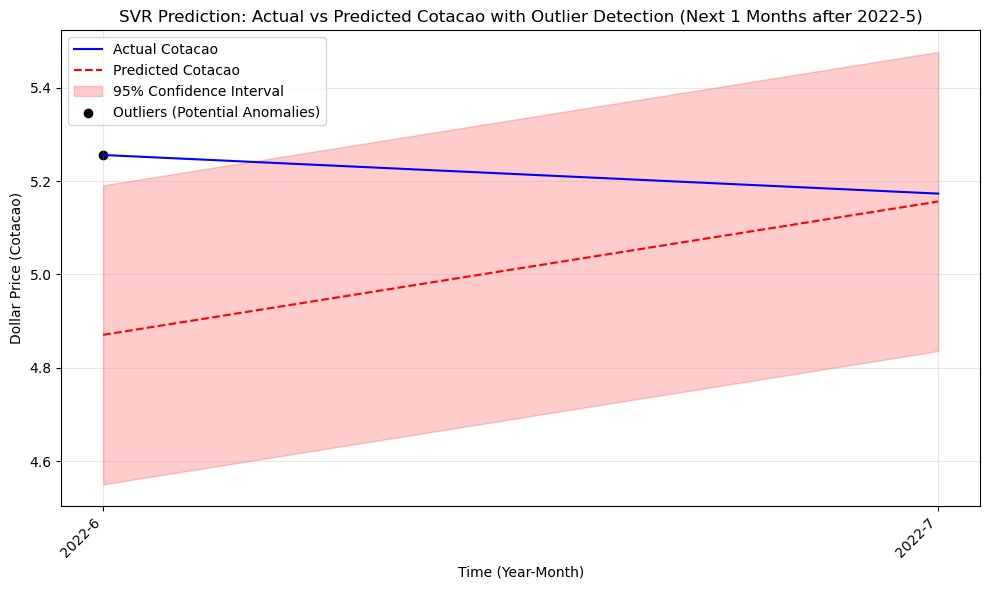

In [59]:
# Specify training period 
train_year = 2022
train_month = 5
window = 1
train_end = df[(df['ano'] == train_year) & (df['mes'] == train_month)].index
train_end = train_end.item()
if pd.isna(train_end):
    raise ValueError(f"No data found for year {train_year} and month {train_month}")
# Define train and test sets
train_idx = train_end + 1  # Index after training period
X_train = X.loc[:train_idx]
y_train = y.loc[:train_idx]
X_test = X.loc[train_idx:train_idx + window]  # Next months for prediction
y_test = y.loc[train_idx:train_idx + window]  # Actual values for the next months

# Scale features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define SVR model and parameters
svr = SVR()
param_grid = {
    'C': (0.1, 1000.0, 'log-uniform'),
    'epsilon': (0.0001, 1.0, 'log-uniform'),
    'gamma': (1e-5, 1.0, 'log-uniform'),
    'kernel': ['rbf']
}

# Time series cross-validation for training data
tscv = TimeSeriesSplit(n_splits=5, test_size=int(len(X_train)*0.1))

# Bayesian optimization
bayes_search = BayesSearchCV(
    estimator=svr,
    search_spaces=param_grid,
    n_iter=40,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42,
    return_train_score=True
)

# Fit model
bayes_search.fit(X_train_scaled, y_train)
best_svr = bayes_search.best_estimator_

# Predict for the test period (next 6 months)
y_pred = best_svr.predict(X_test_scaled)

# Calculate residuals and uncertainty (95% confidence interval)
residuals = y_train - best_svr.predict(X_train_scaled)
std_dev = np.std(residuals)
mul_std = 1.96  # 95% confidence interval
lower_bound = y_pred - mul_std * std_dev
upper_bound = y_pred + mul_std * std_dev

# Identify outliers
outliers_mask = (y_test.values < lower_bound) | (y_test.values > upper_bound)
outliers_df = pd.DataFrame({
    'Date': df.loc[train_idx:train_idx + window]['ano'].astype(str) + '-' + df.loc[train_idx:train_idx + window]['mes'].astype(str),
    'Actual Cotacao': y_test.values,
    'Predicted Cotacao': y_pred,
    'Lower Bound': lower_bound,
    'Upper Bound': upper_bound,
    'Is Outlier': outliers_mask
})
outliers_df = outliers_df[outliers_df['Is Outlier']]

# Print results
print("Best parameters from training:", bayes_search.best_params_)
print(f"CV score (MAE): {-bayes_search.best_score_:.4f}")
print(f"Test MAE (next {window} months): {mean_absolute_error(y_test, y_pred):.4f}")
print(f"Test R² (next {window} months): {r2_score(y_test, y_pred):.4f}")
print(f"\nOutlier Details (Next {window} Months):")
print(outliers_df)

# Visualize results for the next months
plt.figure(figsize=(10, 6))  # Match your plot's size
plot_dates = df.loc[train_idx:train_idx + window]['ano'].astype(str) + '-' + df.loc[train_idx:train_idx + window]['mes'].astype(str)

plt.plot(plot_dates, y_test.values, label="Actual Cotacao", color="blue")
plt.plot(plot_dates, y_pred, label="Predicted Cotacao", color="red", linestyle="--")
plt.fill_between(plot_dates, lower_bound, upper_bound, 
                 color='red', alpha=0.2, label="95% Confidence Interval")
plt.scatter(outliers_df['Date'], outliers_df['Actual Cotacao'], 
            color='black', marker='o', label="Outliers (Potential Anomalies)")

plt.xticks(rotation=45, ha='right')
plt.xlabel("Time (Year-Month)")
plt.ylabel("Dollar Price (Cotacao)")
plt.title(f"SVR Prediction: Actual vs Predicted Cotacao with Outlier Detection (Next {window} Months after {train_year}-{train_month})")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Detect Outliers

In [ ]:
# Load data
file_path = "Dataset_Dolar.csv"
df = pd.read_csv(file_path)
df = df[['t', 'ano', 'mes', 'cotacao', 'ipca_acumulado', 'cpi', 'selic',
         'divida_pp', 'fed_rate']]

# Create lag features (6 months shift)
for shift_val in range(1, 7):
    for column in ['cotacao', 'ipca_acumulado', 'cpi', 'selic', 'divida_pp', 'fed_rate']:
        column_name = f'{column}_lag{shift_val}'
        df[column_name] = df[column].shift(shift_val)
df = df.dropna()  # Drop rows with NaN to avoid bias

# Define features and target
X = df.drop(columns=['t', 'ano', 'mes', 'cotacao', 'ipca_acumulado', 'cpi', 'selic',
                     'divida_pp', 'fed_rate'])  # Use only 6-month-shifted features
y = df['cotacao']

In [ ]:
# Initialize DataFrame for outliers
outliers_df = pd.DataFrame(columns=['Date', 'Actual Cotacao', 'Predicted Cotacao', 
                                  'Lower Bound', 'Upper Bound'])

# Train until end of 2002, then predict and retrain monthly
train_end_2002 = df[df['ano'] == 2002].index[-1]  
current_idx = train_end_2002 + 1  # Start predicting from January 2003

while current_idx < len(df):
    # Define training data (up to current month - 1)
    train_idx = slice(None, current_idx)
    X_train = X.iloc[train_idx]
    y_train = y.iloc[train_idx]

    # Scale features
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # Define SVR model and parameters
    svr = SVR()
    param_grid = {
        'C': (0.1, 1000.0, 'log-uniform'),
        'epsilon': (0.0001, 1.0, 'log-uniform'),
        'gamma': (1e-5, 1.0, 'log-uniform'),
        'kernel': ['rbf']
    }

    # Time series cross-validation for training data
    tscv = TimeSeriesSplit(n_splits=5, test_size=int(len(X_train)*0.1))
    
    # Bayesian optimization
    bayes_search = BayesSearchCV(
        estimator=svr,
        search_spaces=param_grid,
        n_iter=40,
        cv=tscv,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        random_state=42,
        return_train_score=True
    )

    # Fit model
    bayes_search.fit(X_train_scaled, y_train)
    best_svr = bayes_search.best_estimator_

    # Prepare data for prediction (current month)
    X_pred = X.iloc[current_idx:current_idx + 1]
    X_pred_scaled = scaler.transform(X_pred)
    y_actual = y.iloc[current_idx]

    # Predict and calculate uncertainty (std)
    y_pred = best_svr.predict(X_pred_scaled)[0]
    residuals = y_train - best_svr.predict(X_train_scaled)
    std_dev = np.std(residuals)
    mul_std = 1.96  # 95% confidence interval
    lower_bound = y_pred - mul_std * std_dev
    upper_bound = y_pred + mul_std * std_dev

    # Check if actual value is an outlier
    is_outlier = (y_actual < lower_bound) | (y_actual > upper_bound)
    if is_outlier:
        date = f"{df.iloc[current_idx]['ano']}-{df.iloc[current_idx]['mes']}"
        outliers_df = pd.concat([outliers_df, pd.DataFrame({
            'Date': [date],
            'Actual Cotacao': [y_actual],
            'Predicted Cotacao': [y_pred],
            'Lower Bound': [lower_bound],
            'Upper Bound': [upper_bound]
        })])

    # Move to next month
    current_idx += 1

    # Print progress (optional)
    if current_idx % 12 == 0:  # Print every year
        date = f"{df.iloc[current_idx-1]['ano']}-{df.iloc[current_idx-1]['mes']}"
        print(f"Processed up to {date}")

# Print outliers
print("\nOutlier Details:")
print(outliers_df)

In [ ]:
outliers_df

In [2]:
outliers_df

,Date,Actual Cotacao,Predicted Cotacao,Lower Bound,Upper Bound
0,2003.0-7.0,2.9675,2.618538,2.337765,2.899310
0,2003.0-8.0,2.9785,2.667149,2.358205,2.976093
0,2003.0-10.0,2.8665,3.192411,2.929839,3.454984
0,2004.0-9.0,2.8595,3.000525,2.883747,3.117303
0,2008.0-3.0,1.7564,2.400393,2.232297,2.568489
0,2008.0-9.0,1.9066,1.520897,1.242623,1.799171
0,2008.0-10.0,2.1642,1.816898,1.550249,2.083547
0,2008.0-11.0,2.3034,1.994129,1.725078,2.263180
0,2011.0-9.0,1.8790,1.570753,1.337357,1.804150
0,2012.0-3.0,1.8264,1.582597,1.363035,1.802159


In [3]:
#outliers_df.to_csv('Outliers/SVR_Bayesian_Optimization_Outliers.csv',index=False)